In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from repos_tools import read_chembl_screen_results, add_b3db_permeabilities
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GenRev not found, steiner wont work
Import error: Negex. Using keyword matching instead
Import error: Funcassociate. Make sure that funcassociate is in toolbox!


The following SQL scripts extract from ChEMBL information on indications for each drug as well as standard InChi and canonical SMILES.

In [2]:
ls *.sql

drug-indication.sql                 drug_indication-complete-table.sql
drug-info.sql


Import the result of a network based ChEMBL screen

## BBB permeabilities

The blood brain barrier (BBB) permeabilities are taken from the [B3DB](https://github.com/theochem/B3DB); see also [2021-12-11-bbb-permeability](https://github.com/attilagk/CTNS-notebook/tree/main/2021-12-11-bbb-permeability).  B3DB does not specify ChEMBL IDs but it does provide standard InChi, therefore we first read `drug-info.csv` generated by `drug-info.sql` from ChEMBL, which provides a mapping between ChEMBL IDs and InChis for all phase 3 and phase 4 compounds in ChEMBL.

In [3]:
fpath = '../../results/2021-12-13-chembl-drug-info/drug-info.csv'
chembl_ids = pd.read_csv(fpath)
chembl_ids.columns

Index(['drug_chembl_id', 'drug_name', 'standard_inchi', 'canonical_smiles'], dtype='object')

Now we read the entire B3DB.

In [4]:
fpath = '../../resources/B3DB/B3DB_classification.tsv'
dtypes = {'compound_name': 'str', 'IUPAC_name': 'str', 'SMILES': 'str', 'CID': np.float64, 'logBB': np.float64,
         'BBB+/BBB-': 'category', 'Inchi': 'str', 'group': 'category'}
b3db = pd.read_csv(fpath, sep='\t', dtype=dtypes)
b3db.columns

Index(['NO.', 'compound_name', 'IUPAC_name', 'SMILES', 'CID', 'logBB',
       'BBB+/BBB-', 'Inchi', 'threshold', 'reference', 'group', 'comments'],
      dtype='object')

Using the ChEMBL ID $\rightarrow$ InChi mapping we obtain BBB permeability for phase 3 and phase 4 compounds.  As we can see, permeability info (BBB+/BBB-) is missing for many compounds.

In [5]:
chembl_bbb = pd.merge(left=chembl_ids, right=b3db, how='left', left_on='standard_inchi', right_on='Inchi')
chembl_bbb = chembl_bbb.drop(['canonical_smiles', 'NO.', 'compound_name', 'IUPAC_name', 'SMILES', 'CID', 'Inchi', 'threshold', 'reference', 'comments'], axis=1)
chembl_bbb = chembl_bbb.set_index('drug_chembl_id').rename({'group': 'BBB confidence group'}, axis=1)
bbb_path = '../../results/2021-12-13-chembl-drug-info/drug-info-bbb.csv'
chembl_bbb.to_csv(bbb_path, index=True)
chembl_bbb

,drug_name,standard_inchi,logBB,BBB+/BBB-,BBB confidence group
drug_chembl_id,,,,,
CHEMBL1000,CETIRIZINE,InChI=1S/C21H25ClN2O3/c22-19-8-6-18(7-9-19)21(...,NaN,BBB-,B
CHEMBL100116,PENTAZOCINE,InChI=1S/C19H27NO/c1-13(2)7-9-20-10-8-19(4)14(...,0.54,BBB+,A
CHEMBL1002,LEVOSALBUTAMOL,"InChI=1S/C13H21NO3/c1-13(2,3)14-7-12(17)9-4-5-...",NaN,NaN,NaN
CHEMBL100259,URIDINE,InChI=1S/C9H12N2O6/c12-3-4-6(14)7(15)8(17-4)11...,NaN,NaN,NaN
CHEMBL1003,CLAVULANATE POTASSIUM,InChI=1S/C8H9NO5.K/c10-2-1-4-7(8(12)13)9-5(11)...,NaN,NaN,NaN
...,...,...,...,...,...
CHEMBL996,CEFOXITIN,InChI=1S/C16H17N3O7S2/c1-25-16(18-10(20)5-9-3-...,NaN,NaN,NaN
CHEMBL9967,PIRENZEPINE,InChI=1S/C19H21N5O2/c1-22-9-11-23(12-10-22)13-...,NaN,NaN,NaN
CHEMBL997,IBANDRONIC ACID,"InChI=1S/C9H23NO7P2/c1-3-4-5-7-10(2)8-6-9(11,1...",NaN,BBB-,C


In [6]:
prox_path = '../../results/proximity-runs/AD-genes-knowledge-extended-TWAS2plus/AD-genes-knowledge-extended-TWAS2plus.csv'
prox_twas = add_b3db_permeabilities(read_chembl_screen_results(prox_path), bbb_path)

We see that BBB permeability label is missing for most of the drugs of the screen.  These are labeled with `nan` on the following bar chart.

['named-figure/bbb-barplot-chembl-screen.png',
 'named-figure/bbb-barplot-chembl-screen.pdf']

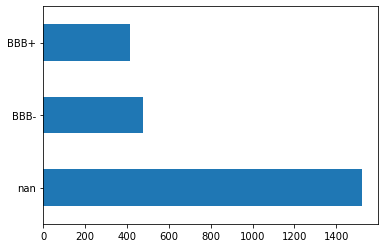

In [7]:
fig, ax = plt.subplots()
prox_twas['BBB+/BBB-'].value_counts(dropna=False).plot(kind='barh', ax=ax)
attila_utils.savefig(fig, 'bbb-barplot-chembl-screen')

The next graph provides more details on permeable (BBB+) and impermeable (BBB-) drugs: confidence groups.

For explanation of confidence groups see below or read article [here](https://www.nature.com/articles/s41597-021-01069-5)

*    Group A: Molecules with numerical data. Several threshold values for log BB have been used to determine if a molecule is BBB permeable or not, including 0, 0.1, −1, (−2, 1). The value of −1 is chosen as the threshold value to define if a compound is BBB+ or BBB− since this is the mostly widely used threshold and maximizes the ease of comparison with other studies.
*    Group B: Molecules from sources that use log BB = −1 as the threshold value, and where all sources agree on the categorical label. The unambiguous label is used.
*    Group C: Molecules where all sources agree on the categorical label, but the sources that do not report their threshold value.
*    Group D: Molecules with two different BBB permeability labels. The most prevalent label is used. In the 45 cases where the two labels occurred with equal frequency, the molecule was discarded.

['named-figure/bbb-barplot-chembl-screen-confidence-groups.png',
 'named-figure/bbb-barplot-chembl-screen-confidence-groups.pdf']

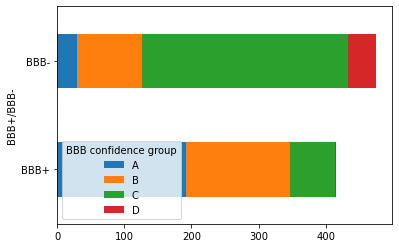

In [8]:
fig, ax = plt.subplots()
vc = prox_twas[['BBB+/BBB-', 'BBB confidence group']].value_counts()
vc = pd.concat([vc.index.to_frame(), vc.to_frame(name='count')], axis=1)
vc = vc.pivot(index='BBB+/BBB-', columns='BBB confidence group', values='count')
vc.plot(kind='barh', stacked=True, ax=ax)
attila_utils.savefig(fig, 'bbb-barplot-chembl-screen-confidence-groups')

## Slightly different results under v2 of the drug-target network

v2 of the drug-target network comes with the extension of targets by drug mechanism.  This section shows that the extension did change the drug-target network, although this affects the results only slightly.  Still, for reproducibility v1 should be used for proximity calculations and v2 only for post-hoc analysis.

The slight difference is related to the extension of the previous (v1) SQL query with molecular mechanisms. At the moment it's unclear what exactly causes the difference.

In [9]:
prox_path = '../../results/proximity-runs/AD-genes-knowledge-extended/AD-genes-knowledge-extended.csv'
prox_path_v2 = '../../results/proximity-runs/AD-genes-knowledge-extended-v2/AD-genes-knowledge-extended-v2.csv'
prox_knowledge = read_chembl_screen_results(prox_path)
prox_knowledge, prox_knowledge_v2 = [add_b3db_permeabilities(read_chembl_screen_results(p), bbb_path) for p in [prox_path, prox_path_v2]]

<AxesSubplot:xlabel='rank', ylabel='delta z'>

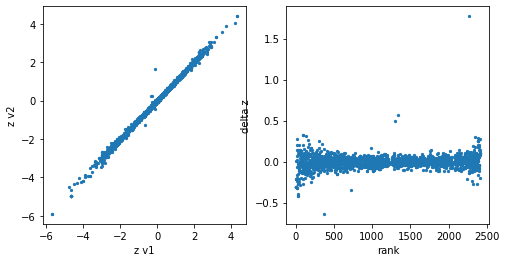

In [10]:
prox_knowledge_v2['z v1'] = prox_knowledge[['z']]
prox_knowledge_v2 = prox_knowledge_v2.rename({'z': 'z v2'}, axis=1)
prox_knowledge_v2['delta z'] = prox_knowledge_v2['z v2'] - prox_knowledge_v2['z v1']
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
prox_knowledge_v2.plot(kind='scatter', x='z v1', y='z v2', marker='.', ax=ax[0])
prox_knowledge_v2.plot(kind='scatter', x='rank', y='delta z', marker='.', ax=ax[1])

## Indications
### Indications for each drug and drugs for each indication

For each compound ChEMBL provides a list of indications and the maximum phase for each of those.  The indications are expressed both with [MeSH](https://www.nlm.nih.gov/mesh/meshhome.html) (Medical Subject Headings) or [EFO](https://www.ebi.ac.uk/efo/) (Experimental Factor Ontology) headings/terms.  Note that:

1. MeSH headings have somewhat coarser granularity than EFO terms so we have more indications expressed by the latter than the former.
1. Restricting indications with increasing `max_phase_for_ind` leads to progressively fewer indications
1. DEXAMETHASONE is investigated/approved for most indications
1. Neoplasms are the most frequent indication in terms of the number of drugs tested for them

In [11]:
def get_indication4screen(ont_id='mesh_id', ont_name='mesh_heading', screendf=prox_twas):
    fpath = '../../results/2021-12-13-chembl-drug-info/drug-indication.csv'
    df = pd.read_csv(fpath, usecols=['drug_chembl_id', 'drug_name', ont_id, ont_name, 'max_phase_for_ind'], index_col=['drug_chembl_id', ont_id])
    df = df.drop_duplicates()
    chembl_ids2drop = set(df.index.get_level_values(0)).difference(set(screendf.index))
    df = df.drop(chembl_ids2drop, axis=0, level=0)
    return(df)

mesh_screen = get_indication4screen(ont_id='mesh_id', ont_name='mesh_heading')
efo_screen = get_indication4screen(ont_id='efo_id', ont_name='efo_term')

mesh_screen.to_csv('../../results/2021-12-13-chembl-drug-info/drug-mesh.csv')
efo_screen.to_csv('../../results/2021-12-13-chembl-drug-info/drug-efo.csv')

def indication_describe(ind_screen, max_phase_at_least):
    val = ind_screen.loc[ind_screen['max_phase_for_ind'] >= max_phase_at_least].drop('max_phase_for_ind', axis=1).describe()
    return(val)

#### MeSH

In [12]:
indication_describe(mesh_screen, 1)

,drug_name,mesh_heading
count,21773,21773
unique,2046,1536
top,DEXAMETHASONE,Neoplasms
freq,233,430


In [13]:
indication_describe(mesh_screen, 3)

,drug_name,mesh_heading
count,9824,9824
unique,1912,1122
top,DEXAMETHASONE,Neoplasms
freq,152,231


In [14]:
indication_describe(mesh_screen, 4)

,drug_name,mesh_heading
count,2730,2730
unique,1349,414
top,DEXAMETHASONE,Neoplasms
freq,66,166


#### EFO

In [15]:
indication_describe(efo_screen, 1)

,drug_name,efo_term
count,23671,23634
unique,2046,1787
top,DEXAMETHASONE,neoplasm
freq,265,357


In [16]:
indication_describe(efo_screen, 3)

,drug_name,efo_term
count,11041,11004
unique,1912,1304
top,DEXAMETHASONE,neoplasm
freq,178,209


In [17]:
indication_describe(efo_screen, 4)

,drug_name,efo_term
count,3049,3012
unique,1349,462
top,DEXAMETHASONE,neoplasm
freq,73,163


### Ranking indications according to number of associated drugs

We see that besides Neoplasms, Cardiovascular Diseases, Depressive Disorder and other common conditions have the most associated drugs.

In [18]:
def indication_frequency(ind_df=mesh_screen, max_phase_at_least=3):
    ind_df = ind_df.loc[ind_df['max_phase_for_ind'] >= max_phase_at_least]
    ind_counts = ind_df.value_counts(ind_df.index.names[1])
    ind_df = ind_df.droplevel('drug_chembl_id', axis=0).drop(['drug_name', 'max_phase_for_ind'], axis=1).drop_duplicates()
    val = pd.concat([ind_counts.to_frame('frequency'), ind_df], axis=1).dropna().astype({'frequency': np.int64})
    val['rank'] = np.arange(len(val)) + 1
    return(val)

mesh_freq = indication_frequency(ind_df=mesh_screen)
efo_freq = indication_frequency(ind_df=efo_screen)

['named-figure/mesh-efo-frequencies.png',
 'named-figure/mesh-efo-frequencies.pdf']

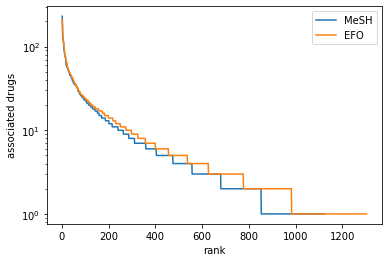

In [19]:
fig, ax = plt.subplots()
mesh_freq.plot('rank', 'frequency', ax=ax, label='MeSH')
efo_freq.plot('rank', 'frequency', ax=ax, label='EFO')
ax.set_yscale('log')
ax.set_ylabel('associated drugs')
attila_utils.savefig(fig, 'mesh-efo-frequencies')

#### Top MeSH headings

In [20]:
mesh_freq.loc[mesh_freq.frequency >= 40]

,frequency,mesh_heading,rank
mesh_id,,,
D009369,231,Neoplasms,1
D002318,166,Cardiovascular Diseases,2
D003866,135,Depressive Disorder,3
D010146,124,Pain,4
D012559,118,Schizophrenia,5
D006973,114,Hypertension,6
D001943,111,Breast Neoplasms,7
D001007,92,Anxiety,8
D003924,92,"Diabetes Mellitus, Type 2",9


#### Selected MeSH headings

In [21]:
sel_ids_mesh = ['D000544', 'D001249', 'D006333', 'D010300', 'D003866']
mesh_freq.loc[sel_ids_mesh]

,frequency,mesh_heading,rank
mesh_id,,,
D000544,44,Alzheimer Disease,39
D001249,58,Asthma,21
D006333,81,Heart Failure,11
D010300,57,Parkinson Disease,22
D003866,135,Depressive Disorder,3


#### Top EFO terms

In [22]:
efo_freq.loc[efo_freq.frequency >= 40]

,frequency,efo_term,rank
efo_id,,,
EFO:0000616,209,neoplasm,1
EFO:0000319,166,cardiovascular disease,2
EFO:0000311,142,cancer,3
EFO:0003843,131,pain,4
EFO:0000692,118,schizophrenia,5
EFO:0000537,114,hypertension,6
MONDO:0002050,114,depressive disorder,7
MONDO:0007254,107,breast cancer,8
EFO:0005230,92,anxiety,9


#### Selected EFO terms

In [23]:
sel_ids_efo = ['EFO:0000249', 'EFO:0000270', 'EFO:0003144', 'EFO:0002508', 'MONDO:0002050']
efo_freq.loc[sel_ids_efo]

,frequency,efo_term,rank
efo_id,,,
EFO:0000249,44,Alzheimer's disease,41
EFO:0000270,62,asthma,21
EFO:0003144,70,heart failure,16
EFO:0002508,57,Parkinson's disease,23
MONDO:0002050,114,depressive disorder,7


### Selected indications for drugs ranked for Alzheimer's

In this section we look at the distribution of the rank of drugs associated to a given indication.

After some data preparation the graphs show that:
1. Drugs previously associated to, investigated for and approved for Alzheimer's disease tend to rank high with the network proximity based screen using the knowledge + TWAS2plus input AD gene set
1. A similar weak tendency is observed for Asthma but not for Heart Failure, Parkinson Disease, or Depressive Disorder

In [24]:
def indication_indicatorf(ind_ids, ind_screen, screendf=prox_twas):
    gb = ind_screen.groupby(axis=0, level=0)
    indifuns = [gb.apply(lambda e: ind_id in e.index.get_level_values(1)) for ind_id in ind_ids]
    indidf = pd.DataFrame(np.array(indifuns).T, columns=ind_ids, index=gb.indices.keys())
    sel_cols = ['drug_name', 'indication_class', 'd', 'avg_d_H0', 'sdev_d_H0', 'z', 'p', 'rank']
    val = pd.concat([screendf[sel_cols], indidf], axis=1, join='inner')
    return(val)

sel_mesh_indifuns = indication_indicatorf(ind_ids=sel_ids_mesh, ind_screen=mesh_screen, screendf=prox_twas)
sel_efo_indifuns = indication_indicatorf(ind_ids=sel_ids_efo, ind_screen=efo_screen, screendf=prox_twas)
sel_mesh_indifuns

,drug_name,indication_class,d,avg_d_H0,sdev_d_H0,z,p,rank,D000544,D001249,D006333,D010300,D003866
CHEMBL3039598,FOSINOPRIL,Antihypertensive; Enzyme Inhibitor (angiotensi...,0.000000,1.953000,0.307881,-6.343350,1.124108e-10,1,False,False,False,False,False
CHEMBL838,BENAZEPRIL,Enzyme Inhibitor (angiotensin-converting),0.000000,1.953000,0.307881,-6.343350,1.124108e-10,2,False,False,False,False,False
CHEMBL1168,RAMIPRIL,Enzyme Inhibitor (angiotensin-converting); Ant...,0.000000,1.953000,0.307881,-6.343350,1.124108e-10,3,False,False,True,False,False
CHEMBL1237,LISINOPRIL,Antihypertensive,0.000000,1.953000,0.307881,-6.343350,1.124108e-10,4,False,False,True,False,False
CHEMBL1581,PERINDOPRIL,"Antihypertensive,Enzyme Inhibitor (angiotensin...",0.000000,1.953000,0.307881,-6.343350,1.124108e-10,5,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL236593,TELCAGEPANT,NaN,2.666667,1.968333,0.196065,3.561736,9.998158e-01,2409,False,False,False,False,False
CHEMBL1197051,ISOXSUPRINE,Vasodilator,2.666667,1.823667,0.235975,3.572408,9.998231e-01,2410,False,False,False,False,False
CHEMBL3716057,GEFAPIXANT,NaN,3.500000,2.190000,0.320780,4.083792,9.999778e-01,2411,False,True,False,False,False
CHEMBL3991065,ATOGEPANT,NaN,3.000000,1.985000,0.227541,4.460731,9.999959e-01,2412,False,False,False,False,False


#### MeSH headings

['named-figure/indication-rank-distribution-mesh.png',
 'named-figure/indication-rank-distribution-mesh.pdf']

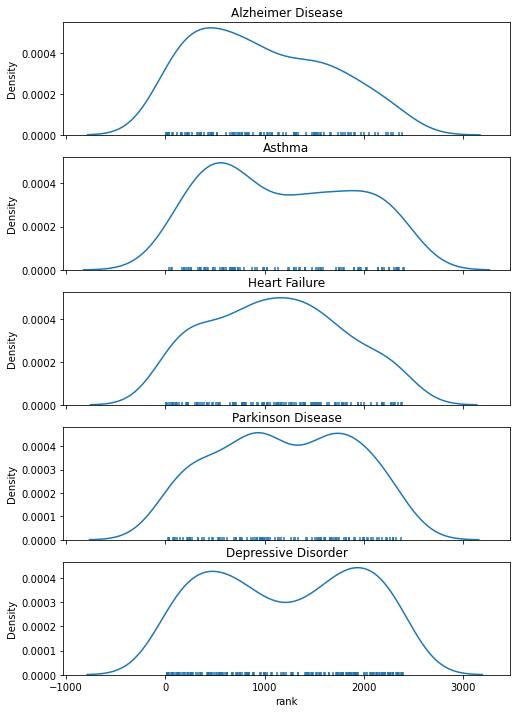

In [25]:
def kde_plots(sel_indifuns=sel_mesh_indifuns, freq_df=mesh_freq):
    sel_ids = sel_indifuns.loc[:, 'rank':].drop('rank', axis=1).columns
    fig, ax = plt.subplots(len(sel_ids), 1, figsize=(8, 12), sharex=True)
    for ind_id, axi in zip(sel_ids, ax):
        ranks = sel_indifuns.loc[sel_indifuns[ind_id], 'rank']
        sns.kdeplot(data=ranks.to_frame('rank'), x='rank', bw_adjust=1, ax=axi)
        axi.scatter(x=ranks, y=[0] * len(ranks), marker='|')
        axi.set_title(freq_df.loc[ind_id, freq_df.columns[1]])
    return((fig, ax))

fig, ax = kde_plots(sel_indifuns=sel_mesh_indifuns, freq_df=mesh_freq)
attila_utils.savefig(fig, 'indication-rank-distribution-mesh')

#### EFO terms

['named-figure/indication-rank-distribution-efo.png',
 'named-figure/indication-rank-distribution-efo.pdf']

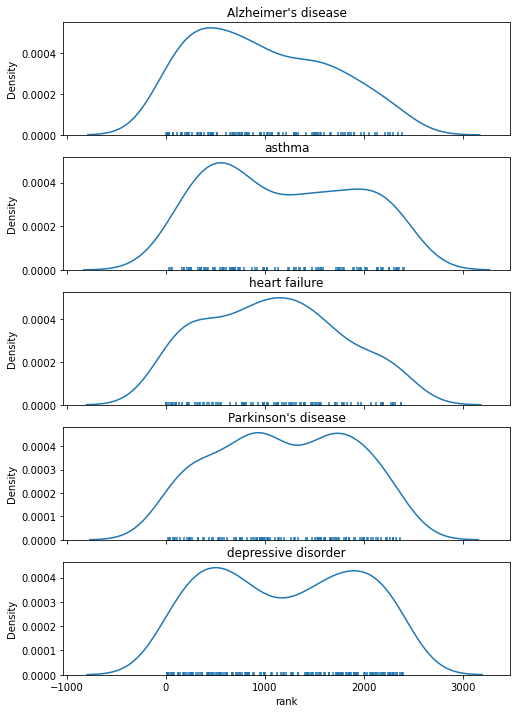

In [26]:
fig, ax = kde_plots(sel_indifuns=sel_efo_indifuns, freq_df=efo_freq)
attila_utils.savefig(fig, 'indication-rank-distribution-efo')

In [27]:
%connect_info

{
  "shell_port": 51850,
  "iopub_port": 51851,
  "stdin_port": 51852,
  "control_port": 51854,
  "hb_port": 51853,
  "ip": "127.0.0.1",
  "key": "bd18f6e5-f62b600972dd1fda394bd567",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-84dff4b7-e2a9-4c0e-917b-cab957c74f81.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
